## Stratification during ENSO

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from scipy.io import loadmat
import numpy as np
import re
from xml.etree import ElementTree as ET
from matplotlib.path import Path
import pandas as pd

In [2]:
ds = xr.open_dataset('../../NHCS/hincast_1980-2015/croco_avg_Y1980M01.nc', 
                     chunks = {'time':1})
ds

<xarray.Dataset> Size: 891MB
Dimensions:     (xi_rho: 602, xi_u: 601, eta_rho: 542, eta_v: 541, s_rho: 32,
                 s_w: 33, time: 1, auxil: 4)
Coordinates: (12/13)
  * xi_rho      (xi_rho) float64 5kB 1.0 2.0 3.0 4.0 ... 599.0 600.0 601.0 602.0
  * xi_u        (xi_u) float64 5kB 1.5 2.5 3.5 4.5 ... 598.5 599.5 600.5 601.5
  * eta_rho     (eta_rho) float64 4kB 1.0 2.0 3.0 4.0 ... 540.0 541.0 542.0
  * eta_v       (eta_v) float64 4kB 1.5 2.5 3.5 4.5 ... 538.5 539.5 540.5 541.5
  * s_rho       (s_rho) float64 256B -0.9844 -0.9531 ... -0.04688 -0.01562
  * s_w         (s_w) float64 264B -1.0 -0.9688 -0.9375 ... -0.0625 -0.03125 0.0
    ...          ...
    lat_rho     (eta_rho, xi_rho) float64 3MB dask.array<chunksize=(542, 602), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
  * time        (time) float32 4B 1.339e+06
Dimensions without coordinates: auxil
Data variables: (12/54)
    spherical   |S1 1B ...
    xl          float64 8B ...
    el          float64 8B ...
    Vtransform  float64 8B ...
    sc_r        (s_rho) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    sc_w        (s_w) float64 264B dask.array<chunksize=(33,), meta=np.ndarray>
    ...          ...
    swflux      (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    radsw       (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_rlw   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_lat   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_sen   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    hel         (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
Attributes: (12/57)
    type:           ROMS restart file
    title:          Peru UW Interannual Run
    date:           
    rst_file:       croco_rst.nc
    his_file:       croco_his.nc
    avg_file:       croco_avg.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL PERU_UW MPI OBC_WEST OBC_NORTH OBC_SOUTH BIOLOGY...

In [3]:
MLD = loadmat("../../NHCS/Processed/WMLD_MLD.mat")
print(MLD.keys())

dict_keys(['__header__', '__version__', '__globals__', 'MLD', 'WMLD'])


In [4]:
# ¨WMLD_MLD
SST = loadmat("../../NHCS/Processed/SST_SSH.mat")
print(SST.keys())

dict_keys(['__header__', '__version__', '__globals__', 'SSH', 'SST'])


In [5]:
# EKMAN_components

Curl = loadmat("../../NHCS/Processed/EKMAN_components.mat")
print(Curl.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Curl', 'Divergence', 'Crosshore_wind', 'VTauy', 'EK_pump', 'UEK', 'VEK', 'LTM_ekpump'])


In [6]:
## mask
print(ds.mask_rho.shape)
mask_rho = ds.mask_rho.values 
mask_nan = np.where(mask_rho, 1, np.nan)
expanded_mask = np.tile(mask_nan[np.newaxis, :, :], (432, 1, 1))
print(expanded_mask.shape)

(542, 602)
(432, 542, 602)


In [91]:
time = pd.date_range(start="1980-01",end="2016-01",freq='M')

Strat_ds = xr.Dataset(
    data_vars={
        'MLD': (("time", "lat","lon"), MLD['MLD'].transpose(2, 1, 0)*expanded_mask),
        'Curl':(("time", "lat","lon"), Curl['Curl'].transpose(2, 1, 0)*-1),
        'SST':(("time", "lat","lon"), SST['SST'].transpose(2, 1, 0)*expanded_mask),
        'SSH':(("time", "lat","lon"), SST['SSH'].transpose(2, 1, 0)*expanded_mask),
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time
}
)

Strat_ds['SSH'] = Strat_ds['SSH']*100
Strat_ds

/tmp/ipykernel_1252466/925912042.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time = pd.date_range(start="1980-01",end="2016-01",freq='M')


<xarray.Dataset> Size: 5GB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float64 5kB -119.0 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float64 4kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    MLD      (time, lat, lon) float64 1GB 0.9402 0.9402 1.335 ... nan nan nan
    Curl     (time, lat, lon) float64 1GB 2.585e-08 3.833e-08 ... nan nan
    SST      (time, lat, lon) float64 1GB 20.19 20.18 20.24 ... nan nan nan
    SSH      (time, lat, lon) float64 1GB 21.2 21.2 21.17 21.16 ... nan nan nan

### ENSO 82-83

In [94]:
Strat_ts = Strat_ds.sel(lat=slice(-16,0),lon=slice(-90,-74))
strat_mmean = Strat_ts.groupby('time.month').mean(dim='time')
strat_anomaly = Strat_ts.groupby('time.month') - strat_mmean

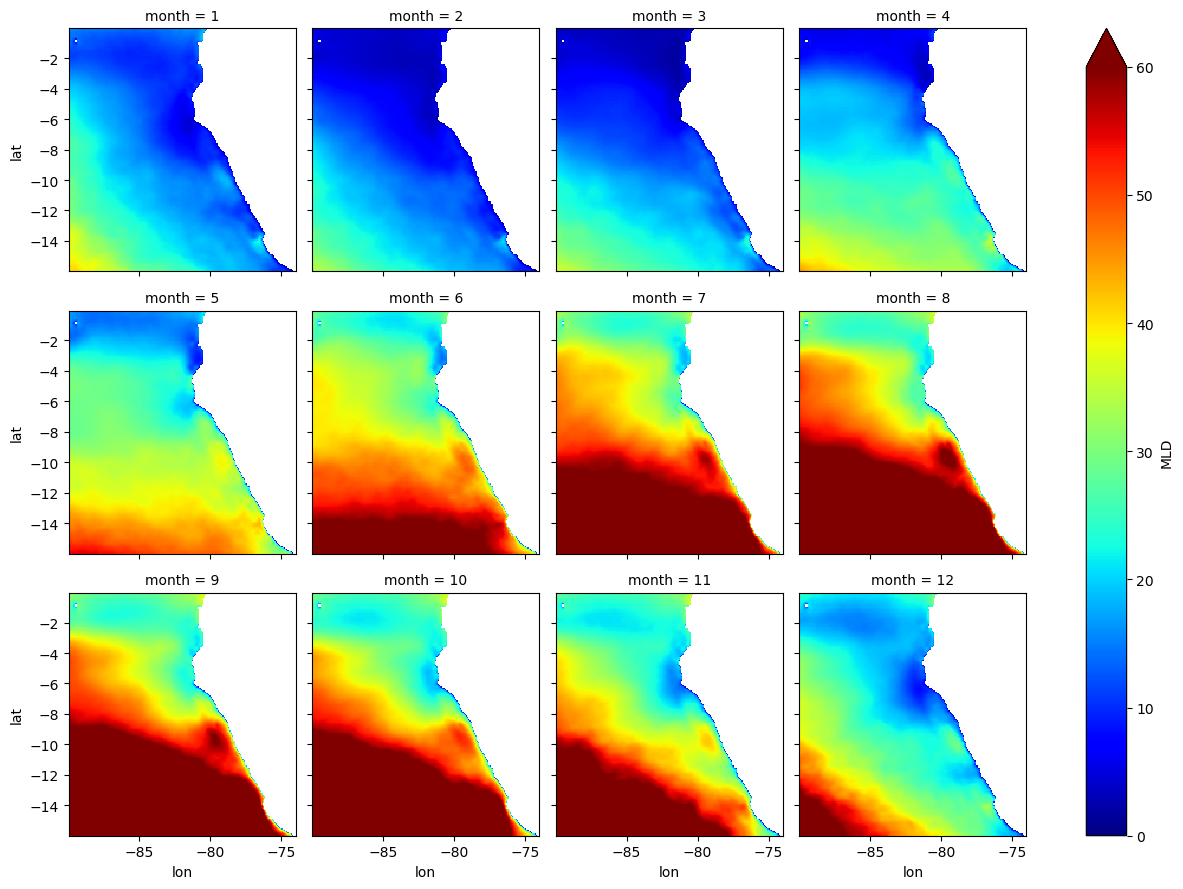

In [75]:
strat_mmean.MLD.plot(x="lon", y="lat", col="month", col_wrap=4, vmin=0,vmax=60,cmap='jet')

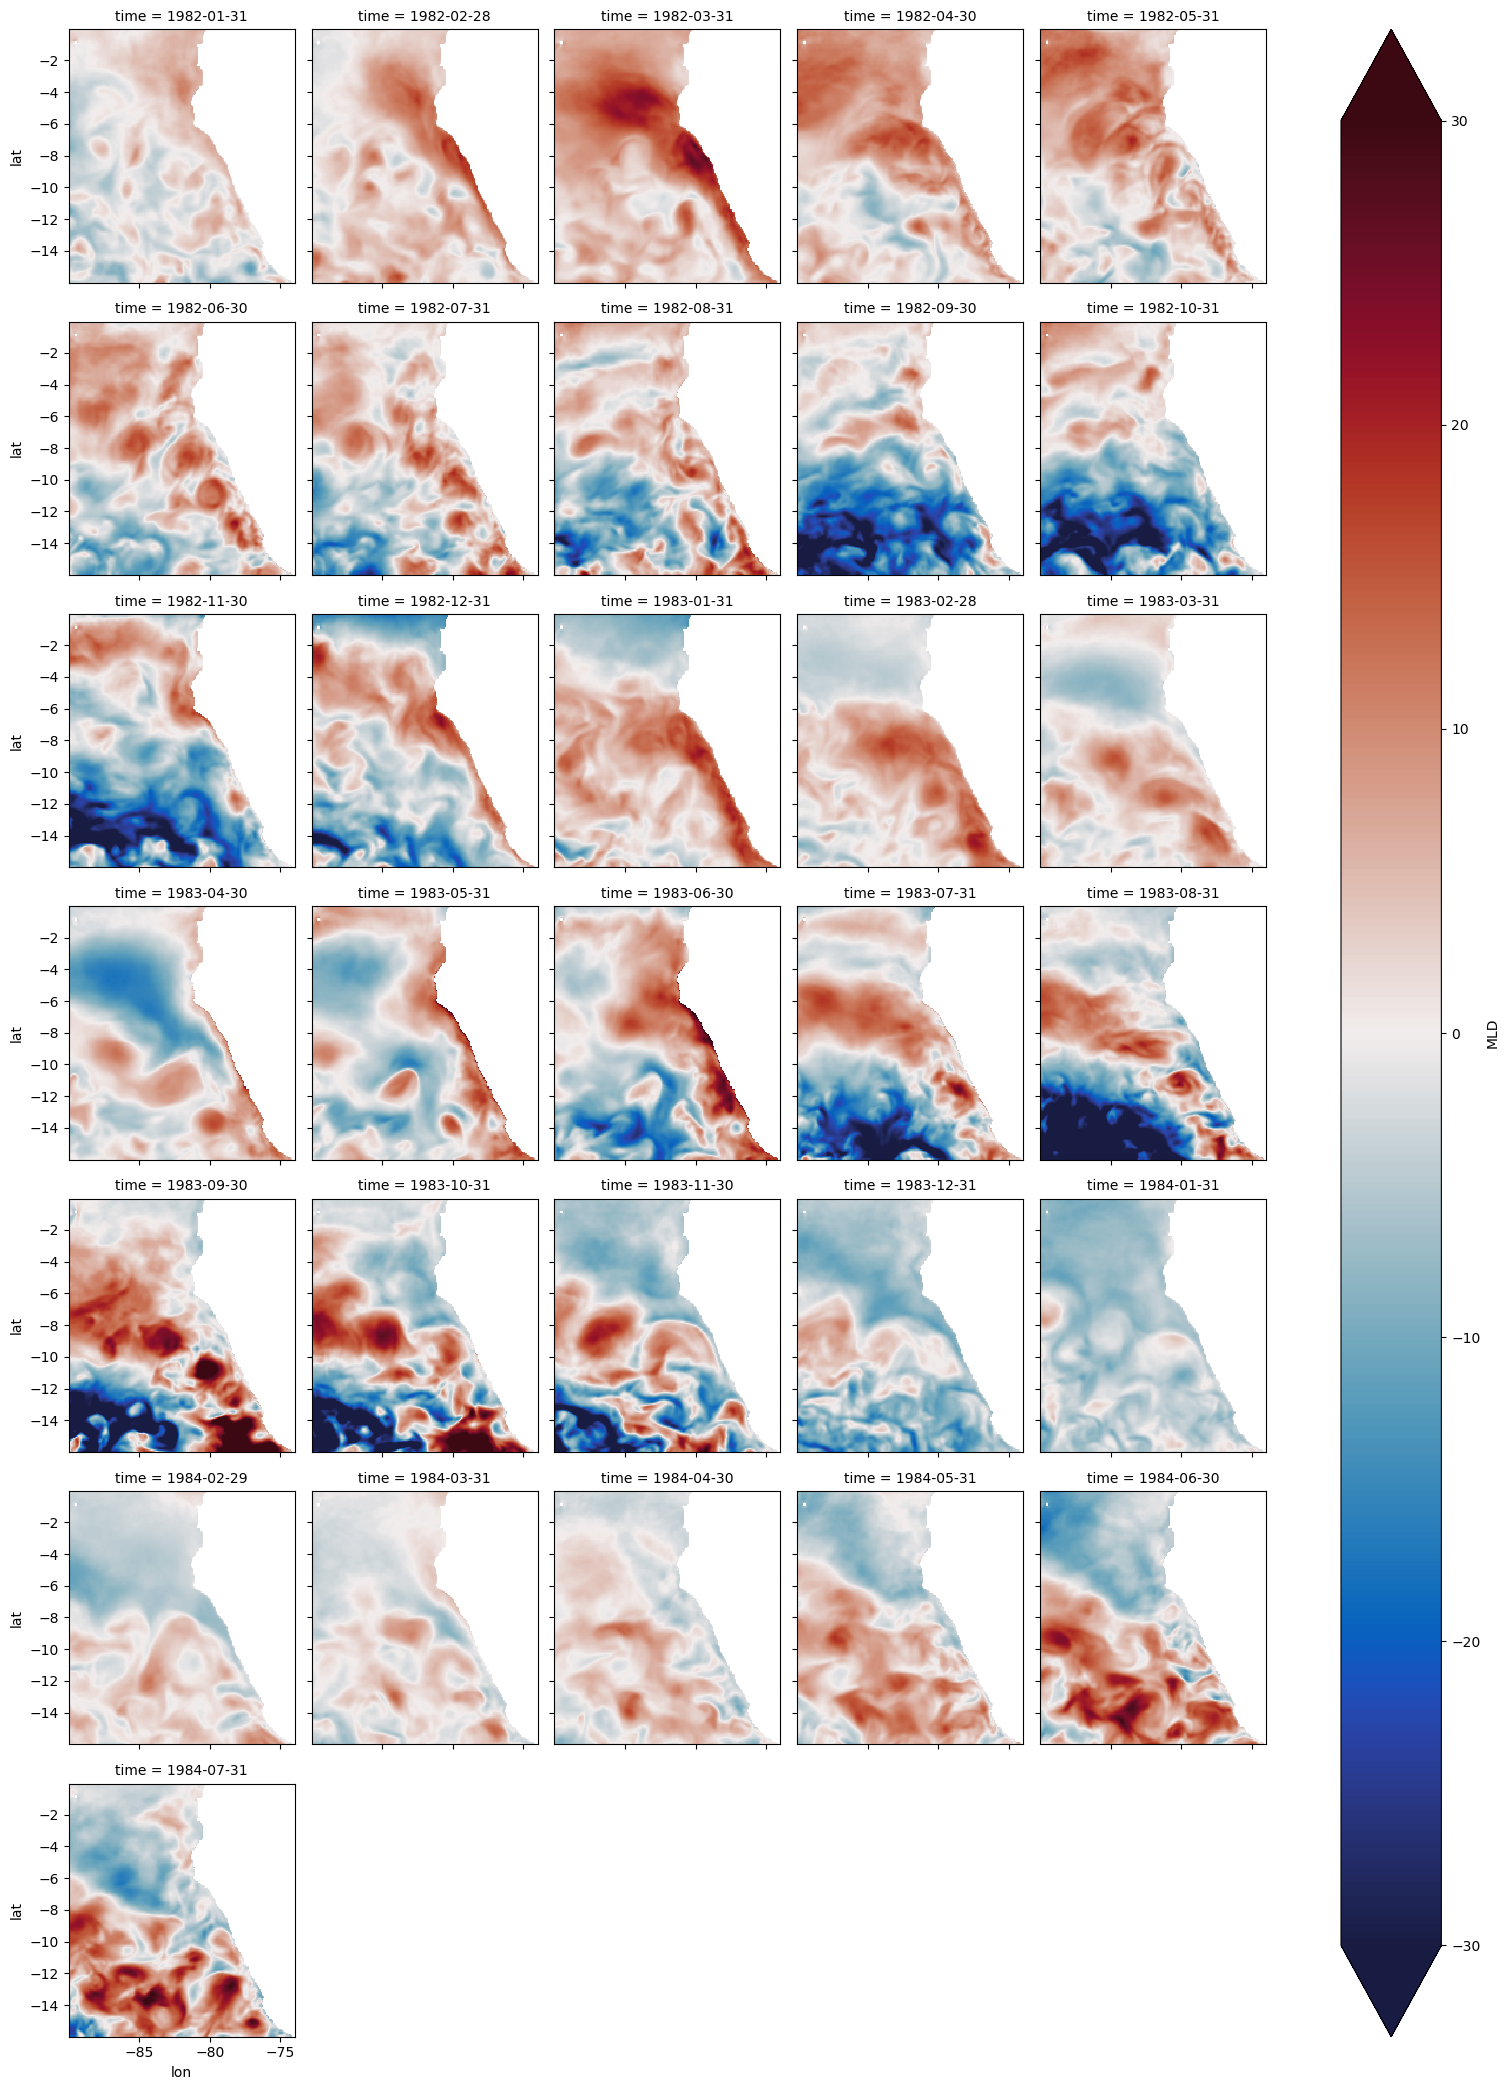

In [76]:
strat_anomaly.MLD.sel(time=slice("1982-01","1984-07")).plot(x="lon", y="lat", col="time", col_wrap=5, vmin=-30,vmax=30,cmap=cm.balance)
# plt.savefig('Figures/MLDa_ENSO_8283'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1252466/3302060145.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


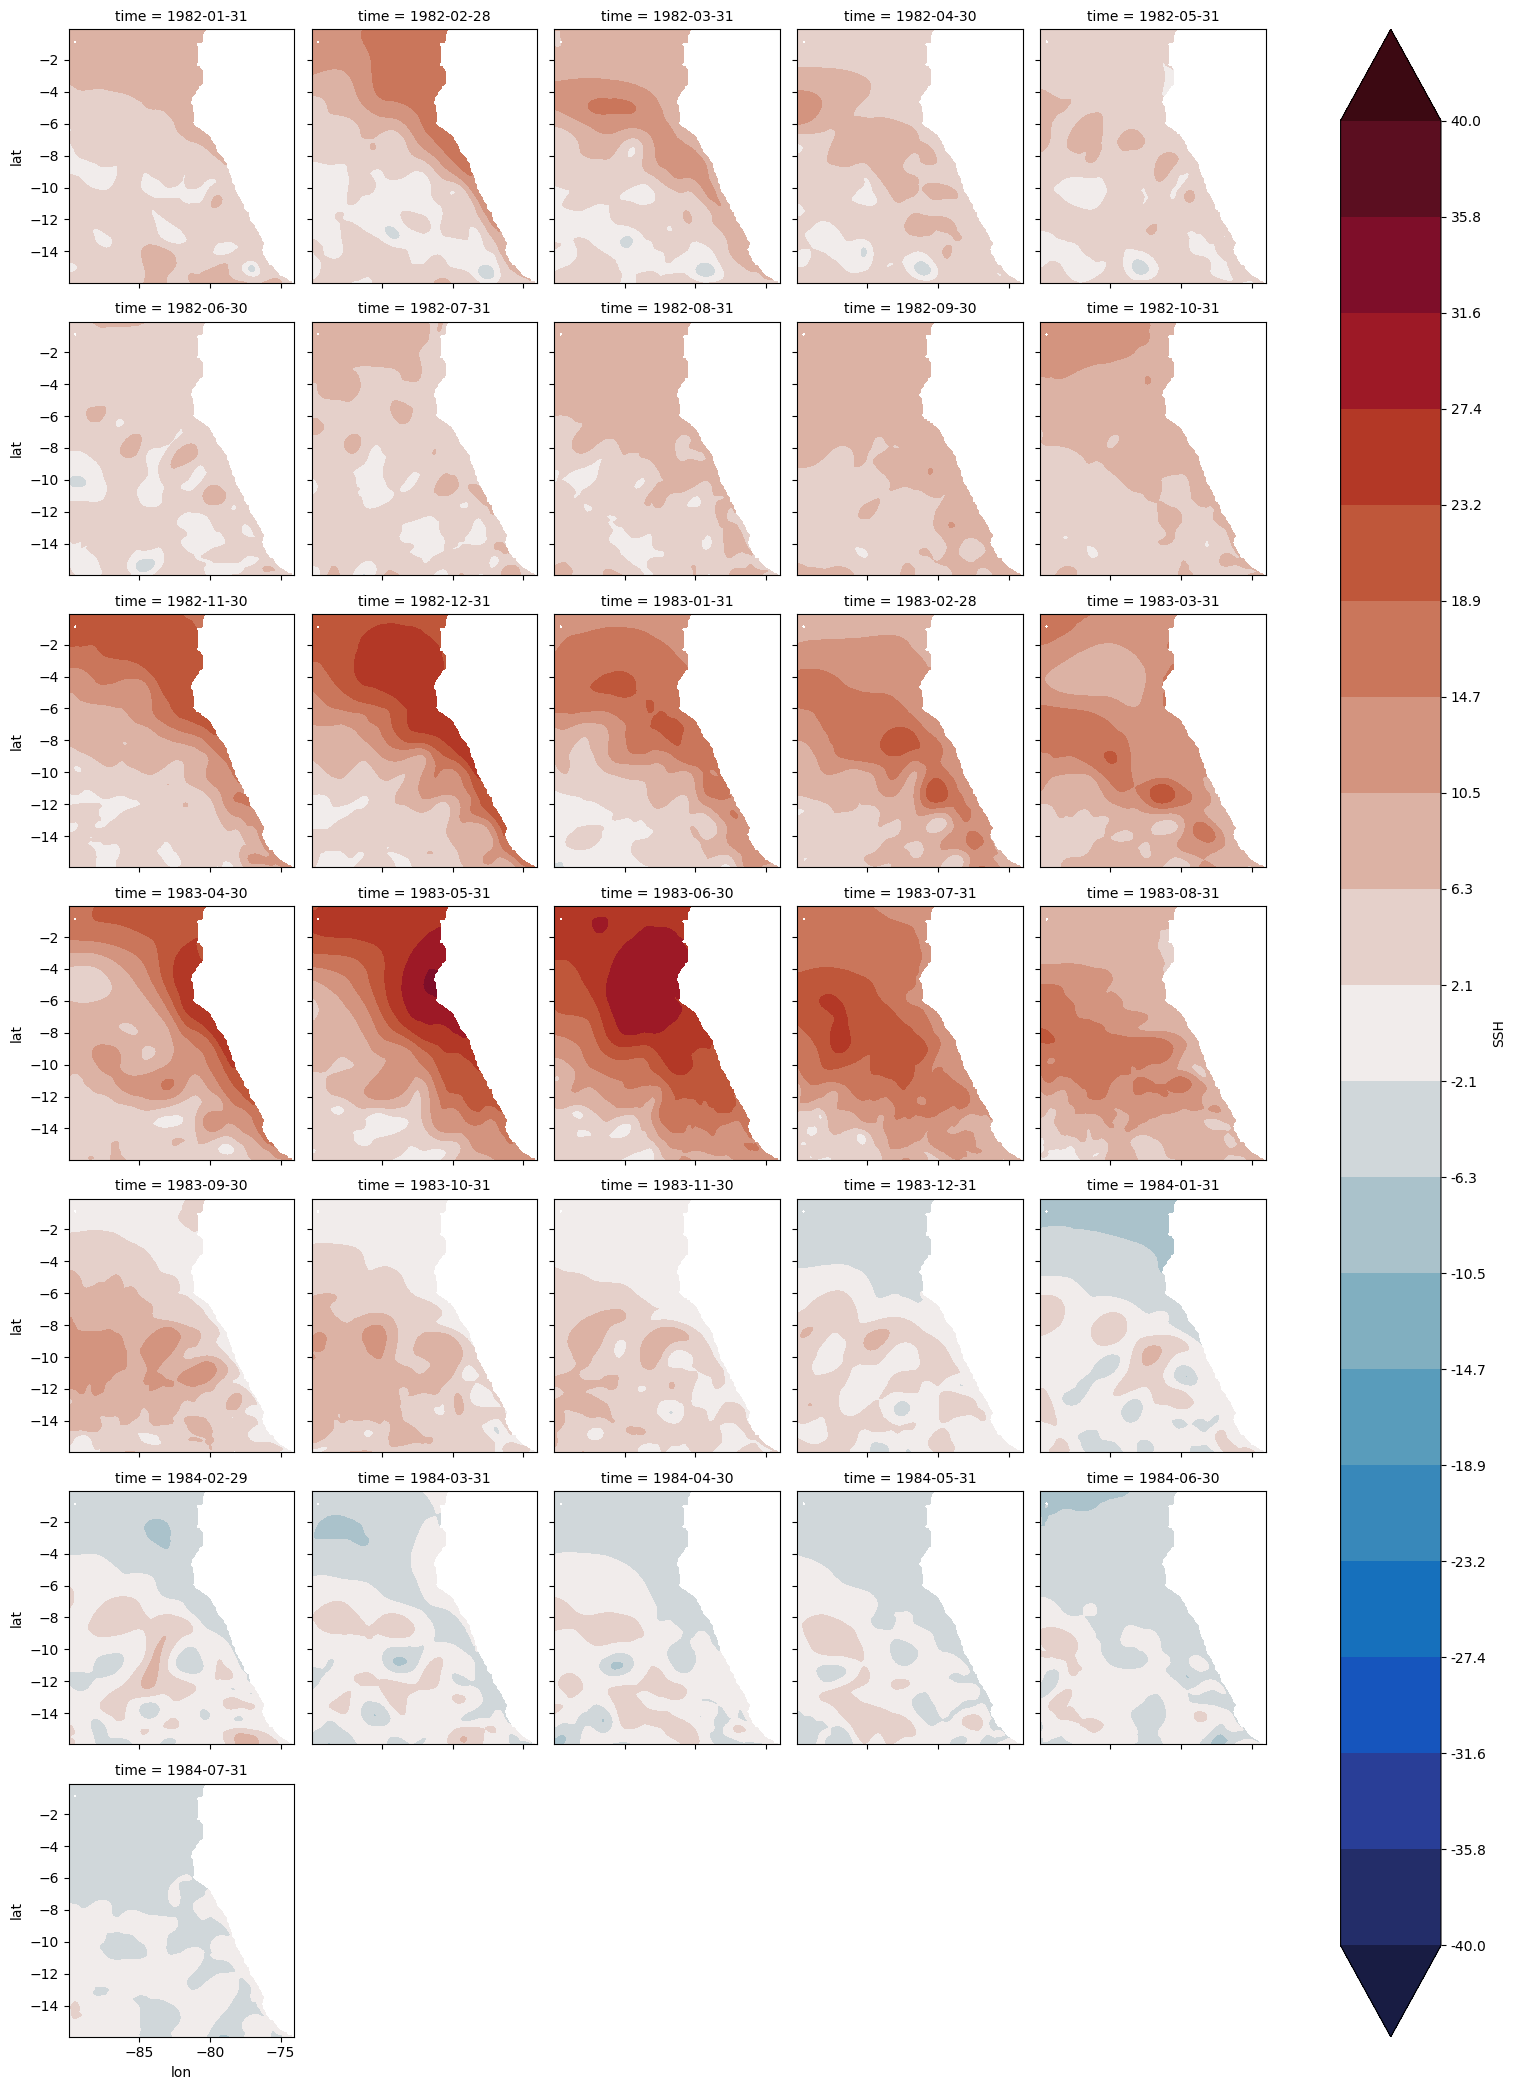

In [96]:
from matplotlib.colors import TwoSlopeNorm 

norm = TwoSlopeNorm(vmin=-40, vcenter=0, vmax=40)
levels=np.linspace(-40,40,20)
# strat_anomaly.SSH.sel(time=slice("1982-01","1984-07")).plot(x="lon", y="lat", col="time", col_wrap=5, vmin=-0.5,vmax=0.5,cmap=cm.balance)

g=strat_anomaly.SSH.sel(time=slice("1982-01","1984-07")).plot.contourf(x="lon", y="lat", col="time", col_wrap=5, vmin=-40,vmax=40,
                                                                     cmap=cm.balance,norm=norm, extend='both',levels=levels)
# # Round the colorbar tick labels
for ax in g.axes.flat:
    if hasattr(ax, "collections") and ax.collections:
        cbar = ax.collections[0].colorbar  # Get colorbar from the first contour collection
        if cbar is not None:
            cbar.set_ticks(levels)  # Set tick positions
            cbar.set_ticklabels([f'{tick:.1f}' for tick in levels])  # Format tick labels


# plt.savefig('Figures/SSHa_ENSO_8283'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

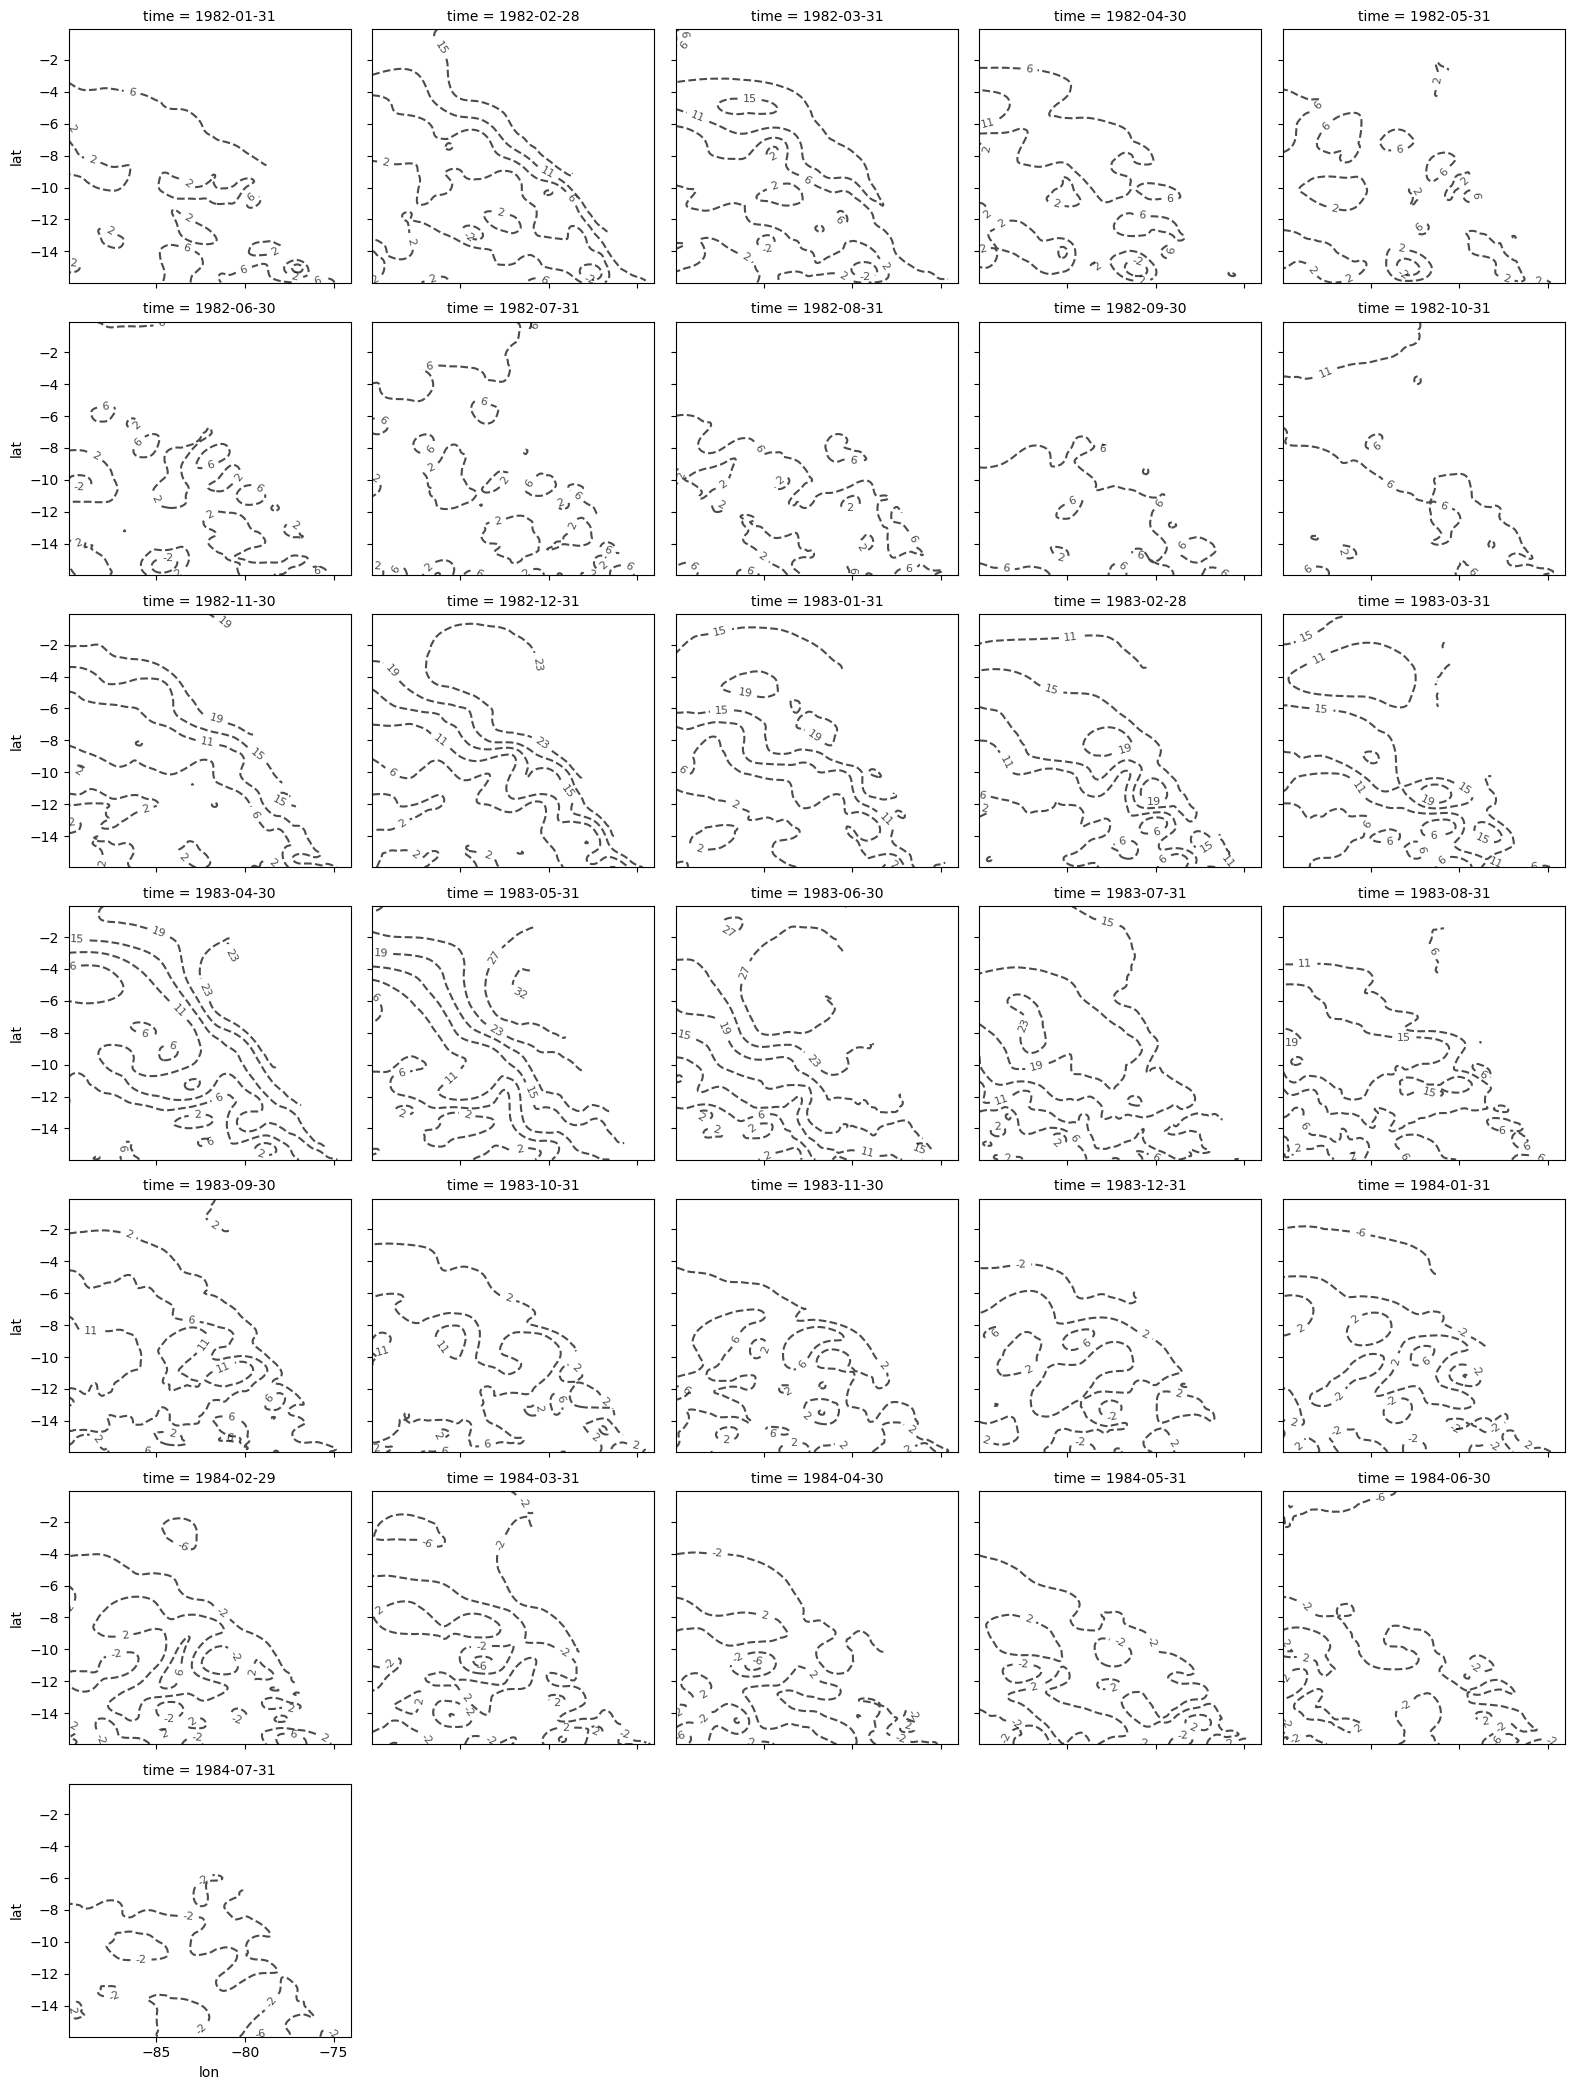

In [103]:
import matplotlib.pyplot as plt

# Create contour plot
g = strat_anomaly.SSH.sel(time=slice("1982-01", "1984-07")).plot.contour(
    x="lon", y="lat", col="time", col_wrap=5,
    colors='black', norm=norm, extend='both', levels=levels, linestyles='--', alpha=0.7,
)

# Loop through each subplot and add labels
for i, ax in enumerate(g.axs.flat):  # Use .axs instead of .axes
    # Get the contour sets created in each subplot
    contour_set = ax.collections  # `collections` contains contour lines
    
    if contour_set:
        ax.clabel(contour_set[0], inline=True, fontsize=8,fmt="%.f")  # Add contour labels

plt.show()


/tmp/ipykernel_1252466/1191283101.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


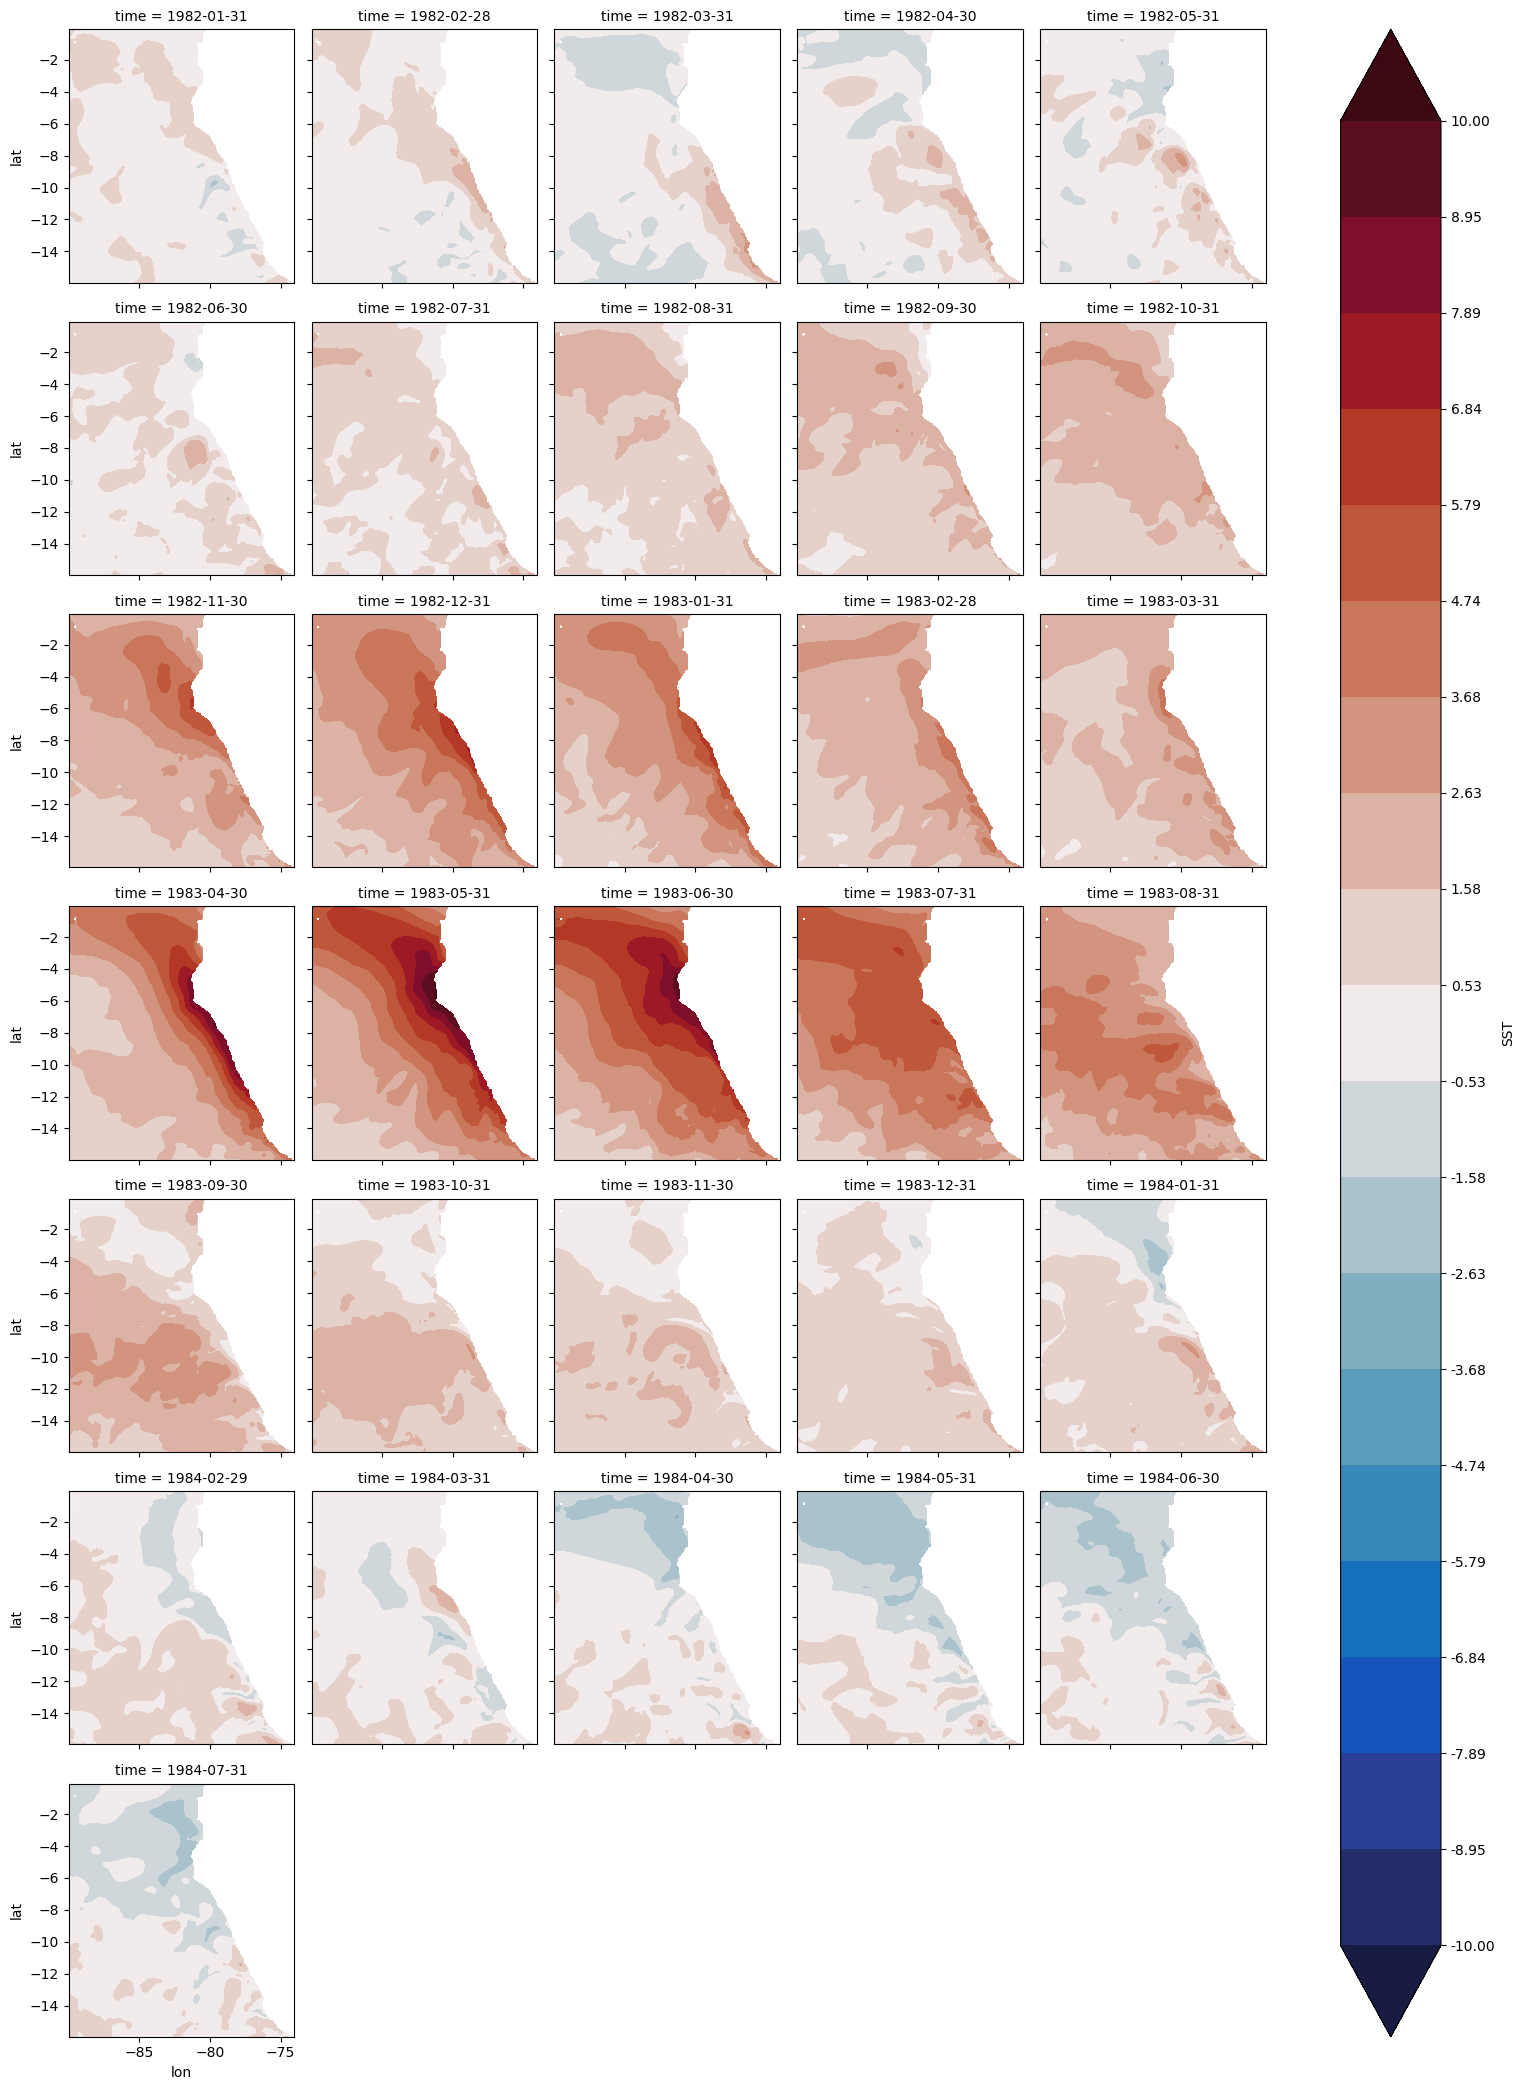

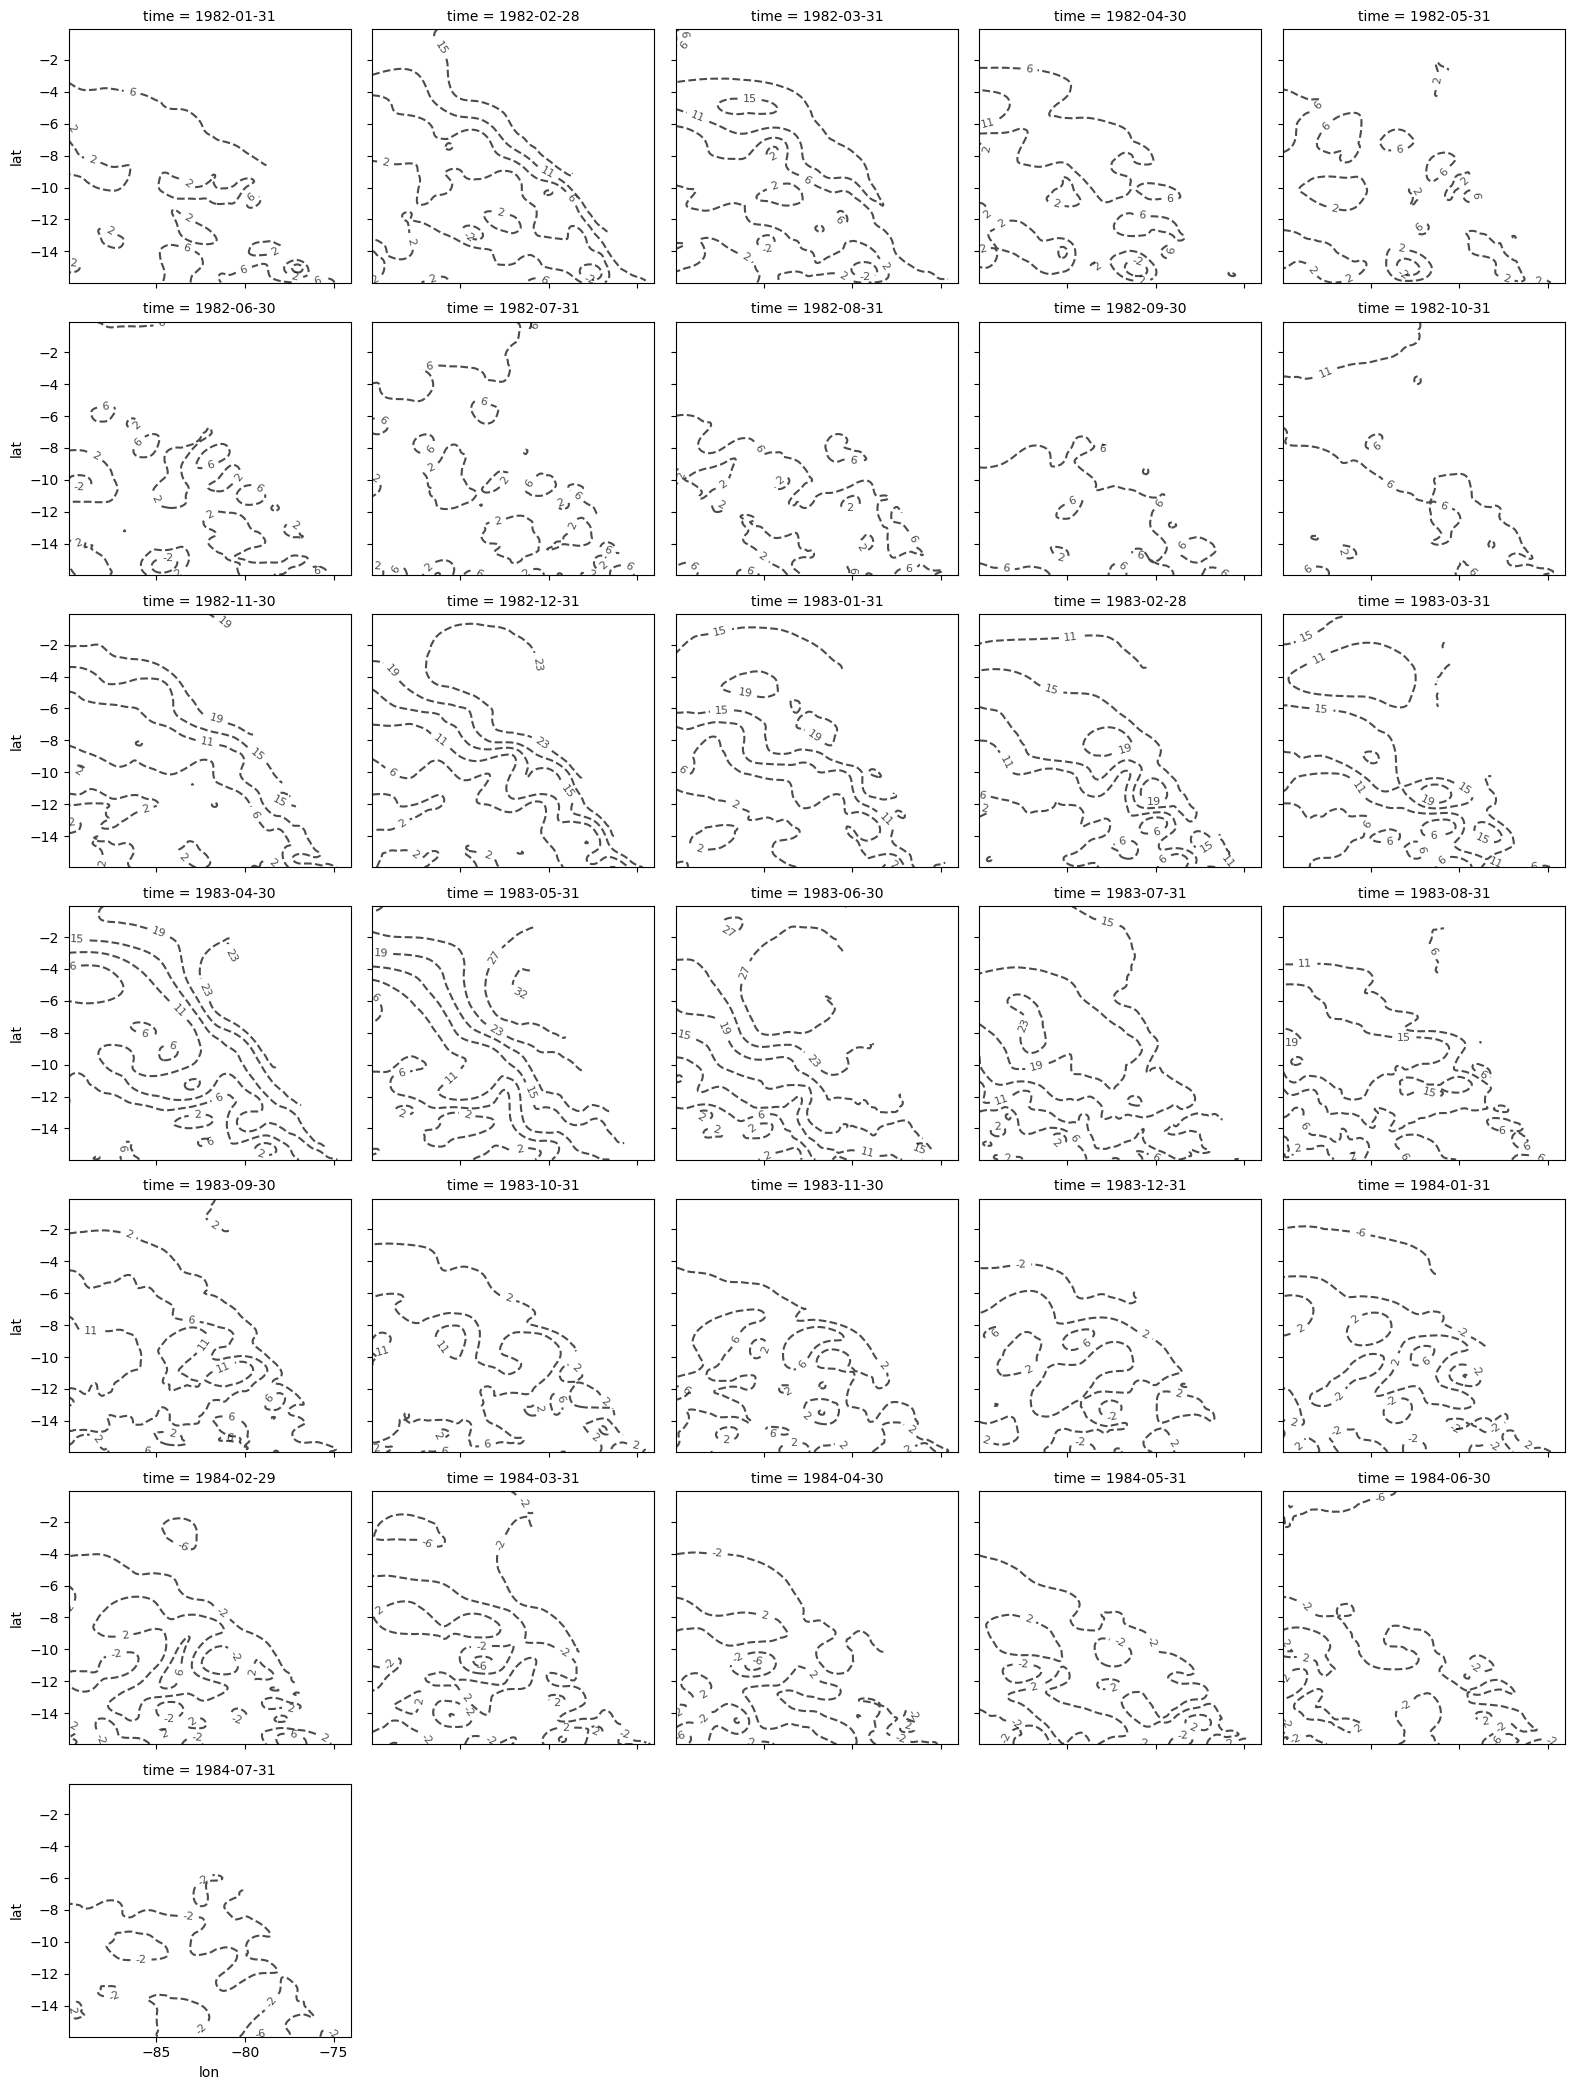

In [105]:
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10)
levels=np.linspace(-10,10,20)
g=strat_anomaly.SST.sel(time=slice("1982-01","1984-07")).plot.contourf(x="lon", y="lat", col="time", col_wrap=5,
                                                                     cmap=cm.balance,norm=norm, extend='both',levels=levels)
# # Round the colorbar tick labels
for ax in g.axes.flat:
    if hasattr(ax, "collections") and ax.collections:
        cbar = ax.collections[0].colorbar  # Get colorbar from the first contour collection
        if cbar is not None:
            cbar.set_ticks(levels)  # Set tick positions
            cbar.set_ticklabels([f'{tick:.2f}' for tick in levels])  # Format tick labels
            
# plt.savefig('Figures/SSTa_ENSO_8283'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()

